# Characterizing and Predicting Dog Adoption Rates

I am using data sets I obtained from Kaggle: [dog breeds parameters scraped from at dogtime.com](https://www.kaggle.com/hocop1/cat-and-dog-breeds-parameters) and the Austin Animal Center's [intake and outake records.](https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes/) 

In [1]:
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from zipfile import ZipFile
from scipy.stats import boxcox
import statsmodels.api as sm

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [2]:
!cd ../data_sets/ & ls

austin-animal-center-shelter-intakes-and-outcomes.zip
BikeShare
Bikeshare-Data.zip
cat-and-dog-breeds-parameters.zip
chicago-red-light-and-speed-camera-data.zip
example_files
Fred_CPI_Foodathome_CUSR0000SAF11.csv
LRUN64TTUSA156S.csv
MORTGAGE30US.csv
music_caps
NYC
ny-city-owned-and-leased-property.zip
OnTheSnow_v1.xlsx
ramen-ratings.csv
ramen-ratings.zip
Readme_file.docx
sentiment_sentences
sentiment_sentences.zip
speed_cam
WELLCOME_APCspend2013_forThinkful.csv


In [3]:
with ZipFile(r'../data_sets/austin-animal-center-shelter-intakes-and-outcomes.zip', 'r') as zip:
    zip.extractall()
with ZipFile(r'../data_sets/cat-and-dog-breeds-parameters.zip', 'r') as zip:
    zip.extractall()

In [4]:
ls

 Volume in drive C is Windows
 Volume Serial Number is 6839-6E71

 Directory of C:\Users\Chris\Documents\thinkful\supervised_learning_capstone

08/17/2019  11:23 PM    <DIR>          .
08/17/2019  11:23 PM    <DIR>          ..
08/08/2019  10:38 PM    <DIR>          .ipynb_checkpoints
08/17/2019  11:24 PM        13,040,169 aac_intakes.csv
08/17/2019  11:24 PM        31,441,583 aac_intakes_outcomes.csv
08/17/2019  11:24 PM        11,648,624 aac_outcomes.csv
08/05/2019  11:43 PM             2,357 Capstone_supervised_learning_notes.ipynb
08/17/2019  11:23 PM           198,688 dog_adoption_SL_capstone.ipynb
08/17/2019  11:24 PM           271,269 rating.json
08/08/2019  12:52 AM               183 README.md
08/09/2019  12:42 AM             7,753 regex fix.ipynb
               8 File(s)     56,610,626 bytes
               3 Dir(s)  24,838,197,248 bytes free


### Shelter dataset exploration and cleaning

In [5]:
raw = pd.read_csv(r'aac_intakes_outcomes.csv')  # I will used the merged file with both intake records and outcome records
shelter_inout_df = raw.copy(deep=True)
shelter_inout_df.head()

,age_upon_outcome,animal_id_outcome,date_of_birth,outcome_subtype,outcome_type,sex_upon_outcome,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_outcome_age_group,outcome_datetime,...,age_upon_intake_age_group,intake_datetime,intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter,time_in_shelter_days
0,10 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,3650,10.0,"(7.5, 10.0]",2017-12-07 14:07:00,...,"(7.5, 10.0]",2017-12-07 00:00:00,12,2017,2017-12,Thursday,14,1.0,0 days 14:07:00.000000000,0.588194
1,7 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,2555,7.0,"(5.0, 7.5]",2014-12-20 16:35:00,...,"(5.0, 7.5]",2014-12-19 10:21:00,12,2014,2014-12,Friday,10,2.0,1 days 06:14:00.000000000,1.259722
2,6 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,2190,6.0,"(5.0, 7.5]",2014-03-08 17:10:00,...,"(5.0, 7.5]",2014-03-07 14:26:00,3,2014,2014-03,Friday,14,3.0,1 days 02:44:00.000000000,1.113889
3,10 years,A047759,2004-04-02 00:00:00,Partner,Transfer,Neutered Male,3650,10.0,"(7.5, 10.0]",2014-04-07 15:12:00,...,"(7.5, 10.0]",2014-04-02 15:55:00,4,2014,2014-04,Wednesday,15,1.0,4 days 23:17:00.000000000,4.970139
4,16 years,A134067,1997-10-16 00:00:00,NaN,Return to Owner,Neutered Male,5840,16.0,"(15.0, 17.5]",2013-11-16 11:54:00,...,"(15.0, 17.5]",2013-11-16 09:02:00,11,2013,2013-11,Saturday,9,1.0,0 days 02:52:00.000000000,0.119444


In [6]:
shelter_inout_df.dtypes

age_upon_outcome               object
animal_id_outcome              object
date_of_birth                  object
outcome_subtype                object
outcome_type                   object
sex_upon_outcome               object
age_upon_outcome_(days)         int64
age_upon_outcome_(years)      float64
age_upon_outcome_age_group     object
outcome_datetime               object
outcome_month                   int64
outcome_year                    int64
outcome_monthyear              object
outcome_weekday                object
outcome_hour                    int64
outcome_number                float64
dob_year                        int64
dob_month                       int64
dob_monthyear                  object
age_upon_intake                object
animal_id_intake               object
animal_type                    object
breed                          object
color                          object
found_location                 object
intake_condition               object
intake_type 

In [7]:
shelter_inout_df.animal_type.unique()

array(['Dog', 'Cat', 'Other', 'Bird'], dtype=object)

In [8]:
#we are only looking at dogs
shelter_inout_df = shelter_inout_df[shelter_inout_df.animal_type == 'Dog']

# there are a lot of features that i'm not interested, especially that describe the same thing in multiple ways. 
# I am using time in shelter as it is a simple scalar, not d datetime. 
#count is only 1, no other values exist

shelter_inout_df = shelter_inout_df.drop(columns=['animal_type', "age_upon_outcome", "animal_id_outcome", "age_upon_outcome_(years)", 
                                                  'age_upon_outcome_(days)', "age_upon_outcome_age_group", "outcome_year", 
                                                  "outcome_monthyear", "outcome_hour", "outcome_number", "animal_id_intake", 
                                                  "age_upon_intake_(years)", "age_upon_intake_age_group", "intake_year", 
                                                  "intake_monthyear", "intake_hour", "intake_number", "time_in_shelter", 
                                                  "found_location", 'outcome_datetime', 'dob_year', 'dob_month', 'dob_monthyear',
                                                  'outcome_month', 'outcome_weekday', 'age_upon_intake', 'intake_month'])
shelter_inout_df.head()

,date_of_birth,outcome_subtype,outcome_type,sex_upon_outcome,breed,color,intake_condition,intake_type,sex_upon_intake,count,age_upon_intake_(days),intake_datetime,intake_weekday,time_in_shelter_days
0,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,Spinone Italiano Mix,Yellow/White,Normal,Stray,Neutered Male,1,3650,2017-12-07 00:00:00,Thursday,0.588194
1,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,Spinone Italiano Mix,Yellow/White,Normal,Public Assist,Neutered Male,1,2555,2014-12-19 10:21:00,Friday,1.259722
2,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,Spinone Italiano Mix,Yellow/White,Normal,Public Assist,Neutered Male,1,2190,2014-03-07 14:26:00,Friday,1.113889
3,2004-04-02 00:00:00,Partner,Transfer,Neutered Male,Dachshund,Tricolor,Normal,Owner Surrender,Neutered Male,1,3650,2014-04-02 15:55:00,Wednesday,4.970139
4,1997-10-16 00:00:00,NaN,Return to Owner,Neutered Male,Shetland Sheepdog,Brown/White,Injured,Public Assist,Neutered Male,1,5840,2013-11-16 09:02:00,Saturday,0.119444


In [9]:
def season_of_date(date_in):
    date = pd.to_datetime(date_in)
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['summer']:
        return 'summer'
    if date in seasons['autumn']:
        return 'autumn'
    else:
        return 'winter'

shelter_inout_df["intake_season"] = shelter_inout_df.intake_datetime.transform(season_of_date)

In [10]:
#these two features have an interaction: if animal was neutered while in shelter
shelter_inout_df.pivot_table(index='sex_upon_intake', columns='sex_upon_outcome', values='count', aggfunc=np.sum)

sex_upon_outcome,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown
sex_upon_intake,,,,,
Intact Female,4139.0,NaN,NaN,8656.0,NaN
Intact Male,NaN,4854.0,9978.0,NaN,NaN
Neutered Male,NaN,NaN,9452.0,NaN,NaN
Spayed Female,NaN,NaN,NaN,8045.0,NaN
Unknown,NaN,NaN,NaN,NaN,241.0


In [11]:
shelter_inout_df[shelter_inout_df.sex_upon_outcome.isna()]

,date_of_birth,outcome_subtype,outcome_type,sex_upon_outcome,breed,color,intake_condition,intake_type,sex_upon_intake,count,age_upon_intake_(days),intake_datetime,intake_weekday,time_in_shelter_days,intake_season
6523,2006-11-17 00:00:00,NaN,Return to Owner,NaN,Dachshund,Brown Merle,Normal,Owner Surrender,NaN,1,2555,2013-11-17 13:15:00,Sunday,10.122222,winter


In [12]:
#change nulls to 'unknown'
shelter_inout_df.loc[shelter_inout_df.sex_upon_intake.isna(), 'sex_upon_intake'] = 'Unknown'
shelter_inout_df.loc[shelter_inout_df.sex_upon_outcome.isna(), 'sex_upon_outcome'] = 'Unknown'

In [91]:
shelter_inout_df["neutered"] = shelter_inout_df.sex_upon_intake.str.split(expand=True)[0]
shelter_inout_df["neutered"] = shelter_inout_df.neutered.apply(lambda x: x!='Intact').astype(int)

shelter_inout_df["male"] = shelter_inout_df.sex_upon_intake.str.split(expand=True)[1]
shelter_inout_df["male"] = shelter_inout_df.male.apply(lambda x: x==Male).astype(int)

#use halfway value for unknowns 
if shelter_inout_df.sex_upon_intake == 'Unknown':
    shelter_inout_df["neutered"] = .5
    shelter_inout_df["male"] = .5


In [75]:
def was_neutered(x):
    intake_type = x.sex_upon_intake.split()[0]
    outcome_type = x.sex_upon_outcome.split()[0]
    if intake_type == outcome_type:
        neutered = 0
    else:
        neutered = 1
    return neutered
shelter_inout_df['neutered_in_shelter'] = shelter_inout_df.apply(was_neutered, axis=1)

In [14]:
shelter_inout_df.isna().sum()

date_of_birth                 0
outcome_subtype           31598
outcome_type                  2
sex_upon_outcome              0
breed                         0
color                         0
intake_condition              0
intake_type                   0
sex_upon_intake               0
count                         0
age_upon_intake_(days)        0
intake_datetime               0
intake_weekday                0
time_in_shelter_days          0
intake_season                 0
neutered                      0
dtype: int64

In [15]:
#outcome is source of nulls
shelter_inout_df.pivot_table(values='breed', index='outcome_type', columns='outcome_subtype', aggfunc=len)

outcome_subtype,Aggressive,At Vet,Barn,Behavior,Court/Investigation,Enroute,Foster,In Foster,In Kennel,In Surgery,Medical,Offsite,Partner,Possible Theft,Rabies Risk,Suffering
outcome_type,,,,,,,,,,,,,,,,
Adoption,NaN,NaN,NaN,NaN,NaN,NaN,2174.0,NaN,NaN,NaN,NaN,254.0,NaN,NaN,NaN,NaN
Died,NaN,15.0,NaN,NaN,NaN,5.0,NaN,18.0,89.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
Euthanasia,492.0,12.0,NaN,133.0,23.0,NaN,NaN,NaN,NaN,NaN,61.0,NaN,NaN,NaN,86.0,690.0
Missing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,NaN,NaN,NaN,NaN,7.0,NaN,NaN
Return to Owner,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Transfer,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9696.0,NaN,NaN,NaN


In [16]:
# some of these outcome subtypes can split outcome types
#TODO

### Import the dog breed descriptions and inspect data

In [17]:
with open('rating.json', 'r') as rating_file:
    ratings = json.load(rating_file)
    json_normalize(ratings)
    dog_descr_df = pd.DataFrame.from_dict(ratings['dog_breeds'], ).T
dog_descr_df.head()

,Adaptability,All Around Friendliness,Exercise Needs,Health Grooming,Trainability,Adapts Well to Apartment Living,Affectionate with Family,Amount Of Shedding,Dog Friendly,Drooling Potential,...,Potential For Playfulness,Potential For Weight Gain,Prey Drive,Sensitivity Level,Size,Tendency To Bark Or Howl,Tolerates Being Alone,Tolerates Cold Weather,Tolerates Hot Weather,Wanderlust Potential
Affenpinscher,3.0,3.0,4.0,2.0,3.0,5.0,5.0,1.0,4.0,1.0,...,4.0,3.0,3.0,3.0,1.0,2.0,1.0,3.0,3.0,2.0
Afghan Hound,4.0,4.0,4.0,2.0,3.0,5.0,5.0,4.0,4.0,1.0,...,4.0,1.0,5.0,5.0,4.0,2.0,2.0,5.0,5.0,5.0
Airedale Terrier,2.0,4.0,5.0,3.0,5.0,1.0,4.0,2.0,4.0,1.0,...,5.0,4.0,5.0,3.0,3.0,4.0,2.0,3.0,3.0,4.0
Akita,3.0,2.0,4.0,4.0,4.0,2.0,5.0,5.0,1.0,5.0,...,5.0,4.0,4.0,5.0,4.0,5.0,1.0,5.0,2.0,4.0
Alaskan Klee Kai,3.0,3.0,4.0,3.0,4.0,3.0,4.0,4.0,2.0,2.0,...,4.0,2.0,5.0,4.0,2.0,3.0,2.0,5.0,2.0,4.0


In [18]:
dog_descr_df.describe()

,Adaptability,All Around Friendliness,Exercise Needs,Health Grooming,Trainability,Adapts Well to Apartment Living,Affectionate with Family,Amount Of Shedding,Dog Friendly,Drooling Potential,...,Potential For Playfulness,Potential For Weight Gain,Prey Drive,Sensitivity Level,Size,Tendency To Bark Or Howl,Tolerates Being Alone,Tolerates Cold Weather,Tolerates Hot Weather,Wanderlust Potential
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,...,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,3.116822,4.070093,4.107477,2.995327,3.560748,3.074766,4.700935,3.014019,3.551402,1.705607,...,4.364486,3.294393,3.593458,3.892523,2.841121,3.121495,2.037383,3.331776,3.074766,3.443925
std,0.565351,0.827771,0.818013,0.601232,0.623146,1.575642,0.560264,1.231355,1.227491,1.215034,...,0.803660,0.950545,1.201780,0.818013,1.155916,1.227313,0.953622,1.209206,0.941490,1.208008
min,2.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,4.000000,4.000000,3.000000,3.000000,1.000000,4.000000,2.000000,3.000000,1.000000,...,4.000000,3.000000,3.000000,3.000000,2.000000,2.000000,1.000000,3.000000,3.000000,3.000000
50%,3.000000,4.000000,4.000000,3.000000,4.000000,3.000000,5.000000,3.000000,4.000000,1.000000,...,5.000000,3.000000,4.000000,4.000000,3.000000,3.000000,2.000000,4.000000,3.000000,4.000000
75%,3.000000,5.000000,5.000000,3.000000,4.000000,5.000000,5.000000,4.000000,5.000000,2.000000,...,5.000000,4.000000,5.000000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000,4.000000
max,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [19]:
dog_descr_df.columns = dog_descr_df.columns.str.strip()
dog_descr_df.columns = dog_descr_df.columns.str.replace(" ", "_")

In [20]:
dog_descr_df.Exercise_Needs.head()

,Exercise_Needs,Exercise_Needs
Affenpinscher,4.0,3.0
Afghan Hound,4.0,4.0
Airedale Terrier,5.0,5.0
Akita,4.0,4.0
Alaskan Klee Kai,4.0,4.0


In [21]:
# Combine two identical features into one
dog_descr_df.columns.get_loc("Exercise_Needs").nonzero()  # get column numbers

(array([ 2, 13], dtype=int64),)

In [22]:
dog_descr_df["Exercise_Need"] = dog_descr_df.iloc[:,[2]] + dog_descr_df.iloc[:,[13]]
dog_descr_df = dog_descr_df.drop(columns=["Exercise_Needs"])
dog_descr_df.loc[:,dog_descr_df.columns.str.contains("Exer*")].head()

,Exercise_Need
Affenpinscher,7.0
Afghan Hound,8.0
Airedale Terrier,10.0
Akita,8.0
Alaskan Klee Kai,8.0


In [23]:
dog_descr_df[dog_descr_df.isna().any(axis=1)]

,Adaptability,All_Around_Friendliness,Health_Grooming,Trainability,Adapts_Well_to_Apartment_Living,Affectionate_with_Family,Amount_Of_Shedding,Dog_Friendly,Drooling_Potential,Easy_To_Groom,...,Potential_For_Weight_Gain,Prey_Drive,Sensitivity_Level,Size,Tendency_To_Bark_Or_Howl,Tolerates_Being_Alone,Tolerates_Cold_Weather,Tolerates_Hot_Weather,Wanderlust_Potential,Exercise_Need
Korean Jindo Dog,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Xoloitzcuintli,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# two rows of just null. These are not helpful.
dog_descr_df = dog_descr_df.dropna(axis=0)

In [25]:
#Should some of these dog features be trimmed?
dog_desc_corr_df = dog_descr_df.corr()

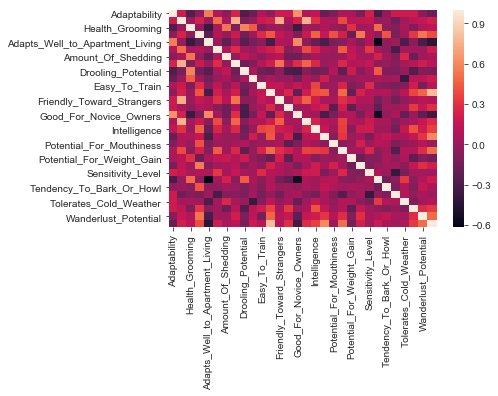

In [26]:
sns.set_style('ticks')
sns.heatmap(dog_desc_corr_df);

In [27]:
#id and remove highly correlated traits to avoid multicolinearity issues in linear reg. models
dog_high_corr = dog_desc_corr_df[(dog_desc_corr_df.abs() > .65) & ~(dog_desc_corr_df == 1)]
for i, row in dog_high_corr.iterrows():
    if row.sum() > 0: 
        print("{} is correlated with: ".format(i), end = '') 
        for ind, col in row.iteritems():
            if ~np.isnan(col):
                print("{} at {}".format(ind, col))
        print("\n")


All_Around_Friendliness is correlated with: Dog_Friendly at 0.7565146009482395
Friendly_Toward_Strangers at 0.7509267951607245
Incredibly_Kid_Friendly_Dogs at 0.7605389789255196


Dog_Friendly is correlated with: All_Around_Friendliness at 0.7565146009482395


Energy_Level is correlated with: Exercise_Need at 0.8029938934844397


Friendly_Toward_Strangers is correlated with: All_Around_Friendliness at 0.7509267951607245


Incredibly_Kid_Friendly_Dogs is correlated with: All_Around_Friendliness at 0.7605389789255196


Exercise_Need is correlated with: Energy_Level at 0.8029938934844397




In [28]:
dog_descr_df = dog_descr_df.drop(columns=["Friendly_Toward_Strangers", "Incredibly_Kid_Friendly_Dogs", "Dog_Friendly", "Intensity",
                                         "Exercise_Need"])

## Feature Augmentation - Combining datasets

I will use the numerical features describing breeds to replace an important but difficult to use feature on the main dataset (dog breed) with a set of ordered numerical features. 


In [29]:
pd.set_option('display.max_columns', 500)

In [30]:
shelter_inout_df[["breed"]].isna().sum()

breed    0
dtype: int64

In [31]:
#we are only getting low match rate.
TEST = pd.merge(left=shelter_inout_df, right=dog_descr_df, left_on="breed", right_index=True)
TEST.shape

(2049, 41)

In [32]:
shelter_inout_df.shape

(45366, 16)

In [33]:
#for bree in shelter_inout_df.breed.unique():
#    print("\'{}\'".format(bree))
shelter_inout_df.breed.value_counts().sort_values(ascending=False).head()

Pit Bull Mix                 6256
Chihuahua Shorthair Mix      4831
Labrador Retriever Mix       4789
German Shepherd Mix          1950
Australian Cattle Dog Mix    1099
Name: breed, dtype: int64

In [34]:
#the breed field from the shelter db has a lot of mixes and multiple breeds listed. Lets clean that.
shelter_inout_df.breed = shelter_inout_df.breed.str.strip()
#Breed name shouldn't be split
shelter_inout_df.breed = shelter_inout_df.breed.str.replace(r'Black/Tan', 'Black and Tan', regex=False)

shelter_inout_df.breed = shelter_inout_df.breed.str.replace(r'(Miniature |Toy |Standard )?Poodle(?=(?:$)|[$\n \/])', 'Poodle',
                                                            regex=True)  # Not sure if should add a feature for poodle type

In [35]:
def replace_abbr(col, old, new, avoid):
    search_string = r'{}(?=(?:$)|[\n \/])(?!{})'.format(old, avoid) #match old, then nl space or slash, but not avoid
    new_col = col.str.replace(search_string, new, regex=True)
    return new_col

In [36]:
# define breed name changes
breed_abbr_fixes = [['Terr', 'Terrier', 'ier'],  # trying to avoid null in lookahead
                   ['Eng', 'English', ''],
                   ['Port', 'Portuguese', ''],
                   ['Span', 'Spaniel', ''],
                   ['Pinsch', 'Pinscher', 'er'],  #null in neg lookahead seems to cause problem
                   ['Catahoula', 'Catahoula Leopard Dog', ' Leopard Dog'],
                   ['Rhod', 'Rhodesian', 'Rhod'],
                   ['Pit Bull', 'American Pit Bull Terrier', ' Terrier'],
                   ['Anatol Shepherd', 'Anatolian Shepherd Dog', ' Dog'],
                   ['German Shepherd', 'German Shepherd Dog', ' Dog'],
                   ['Black and Tan Hound', 'Black and Tan Coonhound', 'Coon']]
for i in breed_abbr_fixes:
    uncorrected, corrected, avoid = i
    shelter_inout_df.breed = replace_abbr(shelter_inout_df.breed, uncorrected, corrected, avoid)

In [37]:
#check breeds now in dataset
shelter_inout_df.breed.value_counts().sort_values(ascending=False).head()

American Pit Bull Terrier Mix    6425
Chihuahua Shorthair Mix          4831
Labrador Retriever Mix           4789
German Shepherd Dog Mix          1950
Australian Cattle Dog Mix        1099
Name: breed, dtype: int64

In [38]:
def pull_cat_out(df, colname, category):
    df[category] = df[colname].str.contains(r'{}'.format(category), regex=True).astype(int)      
    df[colname] = df[colname].str.replace(r'{}'.format(category), '', regex=True)
    return df

In [39]:
breed_cats = ['Shorthair', 'Longhair', 'Wirehair', 'Rough Coat', 'Mix']
for cat_i in breed_cats:
    shelter_inout_df = pull_cat_out(shelter_inout_df, "breed", cat_i)

In [40]:
#reorder columns so i can see column i am using a lot
shelter_inout_df = shelter_inout_df.reindex(columns=(['breed'] + list([a for a in shelter_inout_df.columns if a != 'breed']) ))

In [41]:
shelter_inout_df.breed = shelter_inout_df.breed.str.strip()

In [42]:
# get breed names x & y for x y mix
shelter_inout_df[["breed", "breed2"]] = shelter_inout_df.breed.str.split(pat="/", expand=True, n=1)

In [43]:
shelter_inout_df.breed.value_counts().sort_values(ascending=False).head()

American Pit Bull Terrier    7055
Labrador Retriever           6260
Chihuahua                    5422
German Shepherd Dog          2612
Australian Cattle Dog        1442
Name: breed, dtype: int64

In [44]:
# run again after replacing names
shelter_inout_df.breed = shelter_inout_df.breed.str.strip()
shelter_inout_df.breed2 = shelter_inout_df.breed2.str.strip()

In [45]:
#Breed names with multiple matches - just the Black/Tan. fixed in cell above now.
#NotNeeded shelter_inout_df[shelter_inout_df.breed.str.contains("/[\w\s]+/", regex=True)]["breed"]

In [46]:
#lets find which breed names exist in shelter info but not breed info df, and add add fixes to the feature above
dog_descr_df.index.names = ['breed']  
shelter_dog_list_df = pd.DataFrame(pd.concat([shelter_inout_df.breed, shelter_inout_df.breed2], axis=0) \
                                   ).rename(columns={0:"breed"})
shelter_breed_list_df = pd.merge(left=shelter_dog_list_df, right=dog_descr_df, left_on='breed', right_on="breed", indicator=True,
                                  how='outer')
shelter_only_breeds_df = shelter_breed_list_df[shelter_breed_list_df._merge == 'left_only']
shelter_only_breeds_df["breed"].value_counts().sort_values(ascending=False).head()

Staffordshire        453
Plott Hound          388
Chinese Sharpei      236
Queensland Heeler    210
English Bulldog      131
Name: breed, dtype: int64

In [47]:
#merge dataframes on cleaned breed colombs
shelter_inout_wbreeds_df = pd.merge(left=shelter_inout_df, right=dog_descr_df, left_on="breed", right_index=True, how='left')

In [48]:
shelter_inout_wbreeds_df.describe()

,count,age_upon_intake_(days),time_in_shelter_days,neutered,Shorthair,Longhair,Wirehair,Rough Coat,Mix,Adaptability,All_Around_Friendliness,Health_Grooming,Trainability,Adapts_Well_to_Apartment_Living,Affectionate_with_Family,Amount_Of_Shedding,Drooling_Potential,Easy_To_Groom,Easy_To_Train,Energy_Level,General_Health,Good_For_Novice_Owners,Intelligence,Potential_For_Mouthiness,Potential_For_Playfulness,Potential_For_Weight_Gain,Prey_Drive,Sensitivity_Level,Size,Tendency_To_Bark_Or_Howl,Tolerates_Being_Alone,Tolerates_Cold_Weather,Tolerates_Hot_Weather,Wanderlust_Potential
count,45366.0,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,45366.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000,42815.000000
mean,1.0,978.326456,15.897242,0.410748,0.140171,0.013975,0.004056,0.000794,0.770908,3.014504,4.145019,3.029966,3.705384,3.091276,4.864113,3.429499,1.587761,4.205092,4.025599,4.171809,3.077052,2.788766,4.287866,3.887913,4.590681,3.531192,3.233259,4.321009,2.732243,3.268364,1.733388,2.580591,2.925844,3.264884
std,0.0,1107.420744,44.430504,0.491975,0.347168,0.117389,0.063557,0.028159,0.420253,0.375538,0.687946,0.717494,0.558940,1.556531,0.405888,1.202147,1.000467,1.312164,1.062906,0.871479,0.985374,1.110405,0.683013,1.144478,0.687184,1.020806,1.006814,0.731414,1.209232,0.965666,0.894145,1.183572,0.792617,1.047801
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.0,270.000000,2.093229,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,4.000000,3.000000,3.000000,2.000000,5.000000,2.000000,1.000000,4.000000,4.000000,3.000000,2.000000,2.000000,4.000000,3.000000,4.000000,3.000000,3.000000,4.000000,1.000000,3.000000,1.000000,2.000000,3.000000,2.000000
50%,1.0,730.000000,5.064583,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,4.000000,3.000000,4.000000,3.000000,5.000000,3.000000,1.000000,5.000000,4.000000,4.000000,3.000000,3.000000,4.000000,4.000000,5.000000,3.000000,3.000000,4.000000,3.000000,3.000000,1.000000,3.000000,3.000000,3.000000
75%,1.0,1460.000000,11.116667,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,2.000000,5.000000,5.000000,5.000000,4.000000,4.000000,5.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,2.000000,4.000000,3.000000,4.000000
max,1.0,7300.000000,1606.194444,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [49]:
shelter_inout_wbreeds_df[shelter_inout_wbreeds_df.Adaptability.notna()].shape

(42815, 47)

In [50]:
shelter_inout_wbreeds_df[shelter_inout_wbreeds_df.Adaptability.isna()].shape

(2551, 47)

we have most of the records identified to dog breeds that are in the dog breed description dataset. Most of the remaining most common dog breeds are not in the set or are ambiguous (eg there are two breeds know as 'Staffordshire'. )

In [51]:
shelter_inout_wbreeds_df = shelter_inout_wbreeds_df.dropna(subset=['breed'])


In [52]:
# Average breed data for animals with two breeds listed
#TODO

## Feature Selection

In [54]:
shelter_inout_wbreeds_df.dtypes

breed                               object
date_of_birth                       object
outcome_subtype                     object
outcome_type                        object
sex_upon_outcome                    object
color                               object
intake_condition                    object
intake_type                         object
sex_upon_intake                     object
count                                int64
age_upon_intake_(days)               int64
intake_datetime                     object
intake_weekday                      object
time_in_shelter_days               float64
intake_season                       object
neutered                             int64
Shorthair                            int32
Longhair                             int32
Wirehair                             int32
Rough Coat                           int32
Mix                                  int32
breed2                              object
Adaptability                       float64
All_Around_

In [53]:
X = shelter_inout_wbreeds_df.loc[:,(shelter_inout_wbreeds_df.columns !='time_in_shelter_days') & \
                                 (shelter_inout_wbreeds_df[shelter_inout_wbreeds_df.dtypes != 'object'].values)]
y = shelter_inout_wbreeds_df['time_in_shelter_days']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize=(16, 6))
sns.distplot(y_train);

In [ ]:
# %load ../thinkful_notes/utility/numerical.py
#!/usr/bin/env python

# In[1]:
def winsorize(data=[], lower=5, upper=95):
    '''Winsorizes an array. Defaults are at 5 (%) and 95 (%). 
    '''
    pcts = np.percentile(data, q=[lower, upper])
    w_ized = []
    for i in data:
        if i<pcts[0]:
            w_ized.append(pcts[0])
        elif i>pcts[1]:
            w_ized.append(pcts[1])
        else: 
            w_ized.append(i)
    return w_ized

In [ ]:
#need to figure out why this is a tuple
#y_train = y_train[0]

In [ ]:
#There are some extreme outliers and a significant right skew. First winsorize extreme outliers
y_train = winsorize(data=y_train, lower=0, upper=99)
y_test = winsorize(data=y_test, lower=0, upper=99)  #keep data consistant
#Apply square root transform
y_train = boxcox(np.array(y_train) + .01)  # put in array so can add to each element
y_test = boxcox(np.array(y_test) + .01) 

In [ ]:
plt.figure(figsize=(16, 6))
sns.distplot(y_train[0]);

This is not a normal distribution but much improved.

In [ ]:
X_train

## Modeling

In [ ]:
smX_train = sm.add_constant(X_train)
enet_results = sm.regression.linear_model.OLS(y_train[0], smX_train)
enet_results.fit_regularized(alpha=0.0, L1_wt=1.0)
enet_results.summary()